In [74]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import scipy.signal as signal

# Altimeter Unfiltered

In [80]:
BoB_sla=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021.nc',autoclose=True).sel(latitude=slice(4,25),longitude=slice(78,100)).sla

In [81]:
BoB_sla

<xarray.DataArray 'sla' (time: 9672, latitude: 84, longitude: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
  * longitude  (longitude) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * latitude   (latitude) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88

In [75]:
def butterworth_lowpass_filter(data, order=2, cutoff_freq=1.0/10.0, axis=0):
    """Filter input data.
    
    For unfiltered data, use `cutoff_freq=1`.
    
    Currently, this returns a numpy array.
    """
    B, A = signal.butter(order, cutoff_freq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

In [82]:
BoB_sla_90day_lowpass = butterworth_lowpass_filter(BoB_sla, cutoff_freq=1 / 400.0)


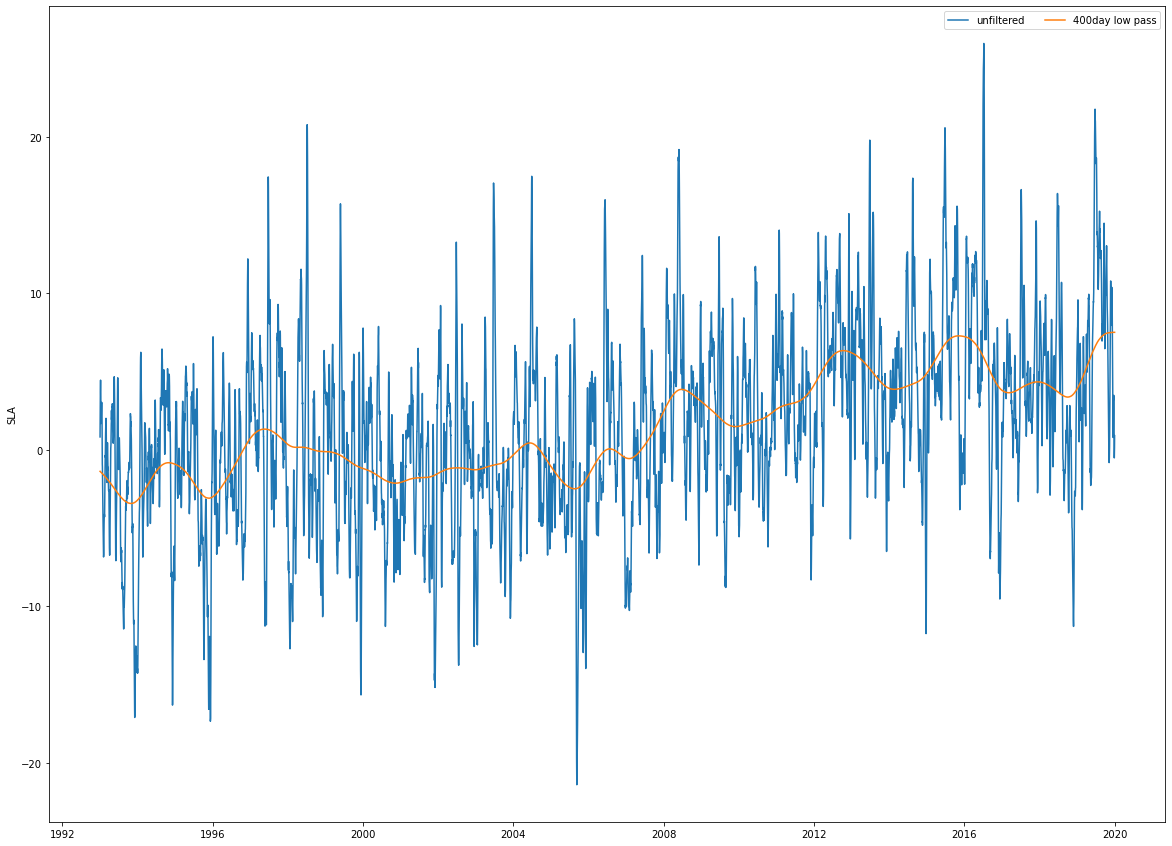

In [94]:
fig, ax = plt.subplots(1, 1, sharex=True,figsize=(20,15))
ax.plot(BoB_sla.coords["time"], BoB_sla[:, 0, 0]);

ax.plot(BoB_sla.coords["time"], BoB_sla_90day_lowpass[:, 0, 0]);
ax.set_ylabel("SLA");
ax.legend(["unfiltered",  "400day low pass"], loc=0, ncol=3);
plt.savefig('bob_sla_trend.jpg',dpi=100)

# Altimeter Filtered

In [2]:
BoB_new_filtered=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021_low_new.nc')

In [61]:
BoB_altimeter_new=BoB_new_filtered.sel(TIME=slice('1993-01-01','2021-01-04'),LONGITUDE=slice(78,100),LATITUDE=slice(4,25))

In [62]:
BoB_altimeter_new=BoB_altimeter_new.SLA_LOW
BoB_altimeter_new

<xarray.DataArray 'SLA_LOW' (TIME: 9672, LATITUDE: 84, LONGITUDE: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * LATITUDE   (LATITUDE) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88
  * TIME       (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
Attributes:
    long_name:  LSL_LOWPASS(SLA,400,400)
    history:    From IO_sla_new

In [63]:
BoB_altimeter_new.to_netcdf('BoB_filtered_altimeter_new.nc')

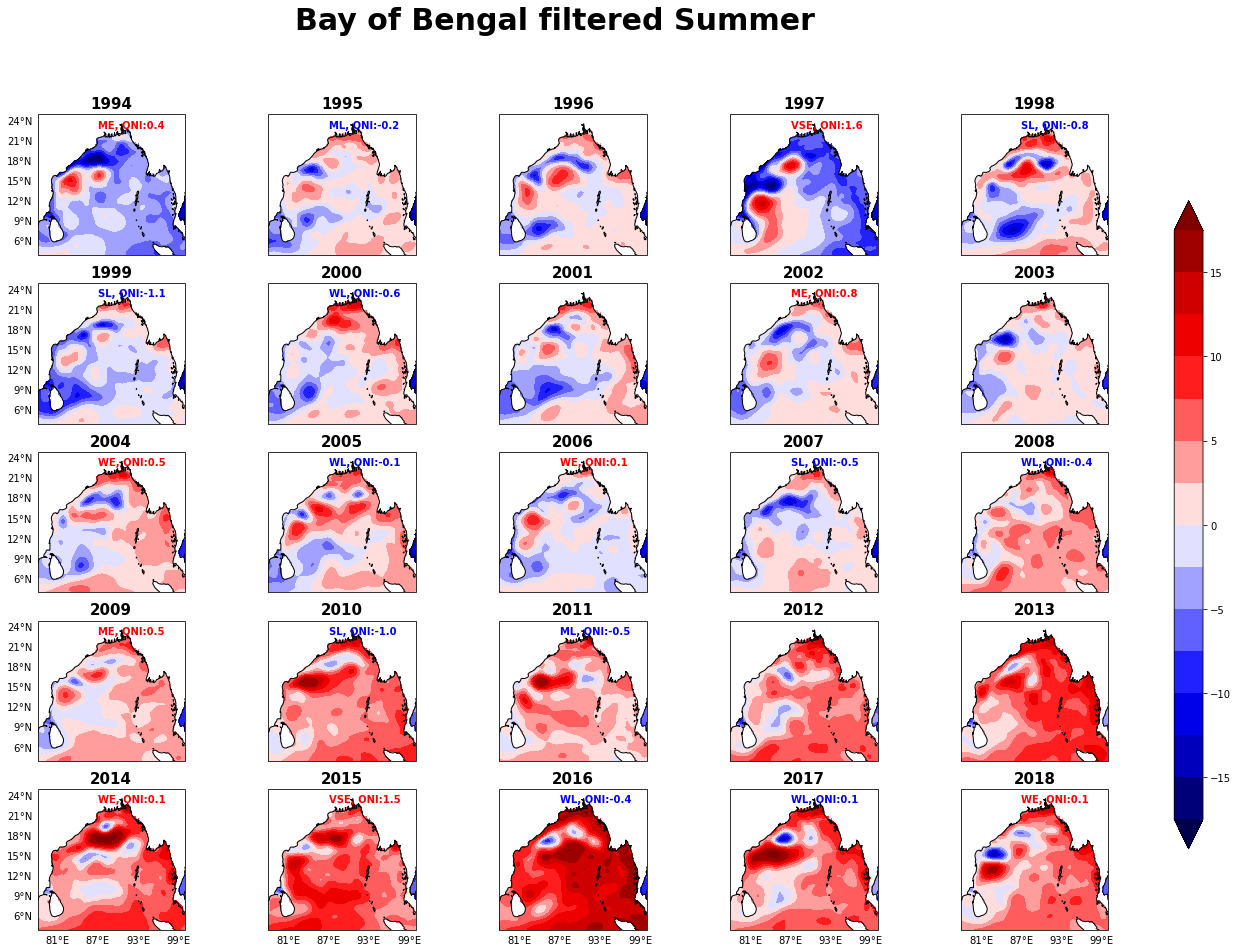

In [24]:
########## Data ########
AS_unfiltered_summer={}
for i in range(1994,2019):
    summer_unfiltered=BoB_new_filtered.sel(TIME=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='TIME').SLA_LOW
    AS_unfiltered_summer[i]=[]
    AS_unfiltered_summer[i].append(summer_unfiltered)
    
########## Info ######
Summer_enso_info={}
Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                    1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                    2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                    2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                    2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                    2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]

##########   Ploting ###########
fig, axs = plt.subplots(nrows=5,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

axs=axs.flatten()
y_label=set([0,5,10,15,20])
x_label=set([20,21,22,23,24])
levels=[-20,-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15,20]
for i,year in enumerate(AS_unfiltered_summer):
        data=AS_unfiltered_summer[year]
        cs=axs[i].contourf(BoB_new_filtered.LONGITUDE.data,BoB_new_filtered.LATITUDE.data,data[0],
                          levels=levels,transform = ccrs.PlateCarree(),
                          cmap='seismic',extend='both')
        axs[i].set_extent([78,100,4,25])
        axs[i].set_title(year,fontsize = 15, weight='bold')
        axs[i].coastlines()
        if i in y_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.bottom_labels = False
            gl.right_labels = False
            #gl.xlines=False
        if i in x_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.left_labels = False
            gl.right_labels = False
        if year in Elnino_years:
            axs[i].text(87,23, Summer_enso_info[year],color='red', fontsize = 10,weight='bold')
        if year in Lanina_years:
            axs[i].text(87,23, Summer_enso_info[year],color='blue', fontsize = 10,weight='bold')

cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
cba=fig.colorbar(cs,cax=cb_ax)
plt.suptitle("Bay of Bengal filtered Summer",fontsize = 30,weight='bold',fontname='Times New Roman')
plt.savefig('BoB_filtered.jpg',dpi=100)

# LCS data

In [46]:
lcs=xr.open_mfdataset('/home/NCAOR/supriyog/model_lcs/lcs_output_IO_91_20.nc')

In [9]:
BoB_LCSCR_new=LCSCR.sel(time=slice('1993-01-01','2021-01-04'),lon=slice(78,100),lat=slice(4,25))

In [10]:
BoB_LCSCR_new=BoB_LCSCR_new.sla
BoB_LCSCR_new

<xarray.DataArray 'sla' (time: 10231, lat: 211, lon: 221)>
dask.array<getitem, shape=(10231, 211, 221), dtype=float32, chunksize=(10231, 211, 221), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01T12:00:00 ... 2021-01-04T12:00:00
  * lon      (lon) float32 78.0 78.1 78.2 78.3 78.4 ... 99.7 99.8 99.9 100.0
  * lat      (lat) float32 4.0 4.1 4.2 4.3 4.4 4.5 ... 24.6 24.7 24.8 24.9 25.0

In [85]:
lcs_sl=lcs
lcs_sl['sla']=lcs.pn/980
#lcs_sl=lcs_sl.sla


In [81]:
lcs_sl_clim=lcs_sl.sel(time=slice('2000-01-01','2010-01-01')).mean(dim='time')

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


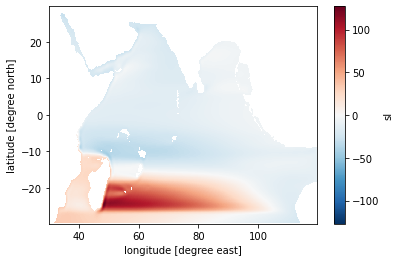

In [63]:
lcs_sl_clim.plot()

In [86]:
lcs_sla=lcs_sl.sla-lcs_sl_clim

In [87]:
lcs_sla

<xarray.DataArray 'sla' (time: 10962, lat: 596, lon: 896)>
dask.array<sub, shape=(10962, 596, 896), dtype=float32, chunksize=(10962, 596, 896), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01T12:00:00 ... 2021-01-04T12:00:00
  * lon      (lon) float32 30.2 30.3 30.4 30.5 30.6 ... 119.4 119.5 119.6 119.7
  * lat      (lat) float32 -29.8 -29.7 -29.6 -29.5 -29.4 ... 29.4 29.5 29.6 29.7

In [ ]:
BoB_LCSCR_new=lcs_sla.sel(time=slice('1993-01-01','2021-01-04'),lon=slice(78,100),lat=slice(4,25))

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


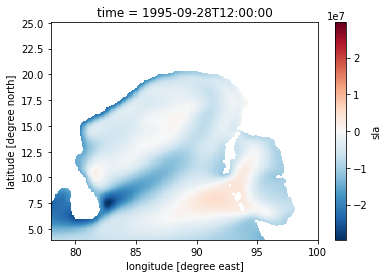

In [72]:
BoB_LCSCR_new[1000].plot()

In [88]:
lcs_sla.to_netcdf('lcs_sla1.nc')

/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


KeyboardInterrupt: 

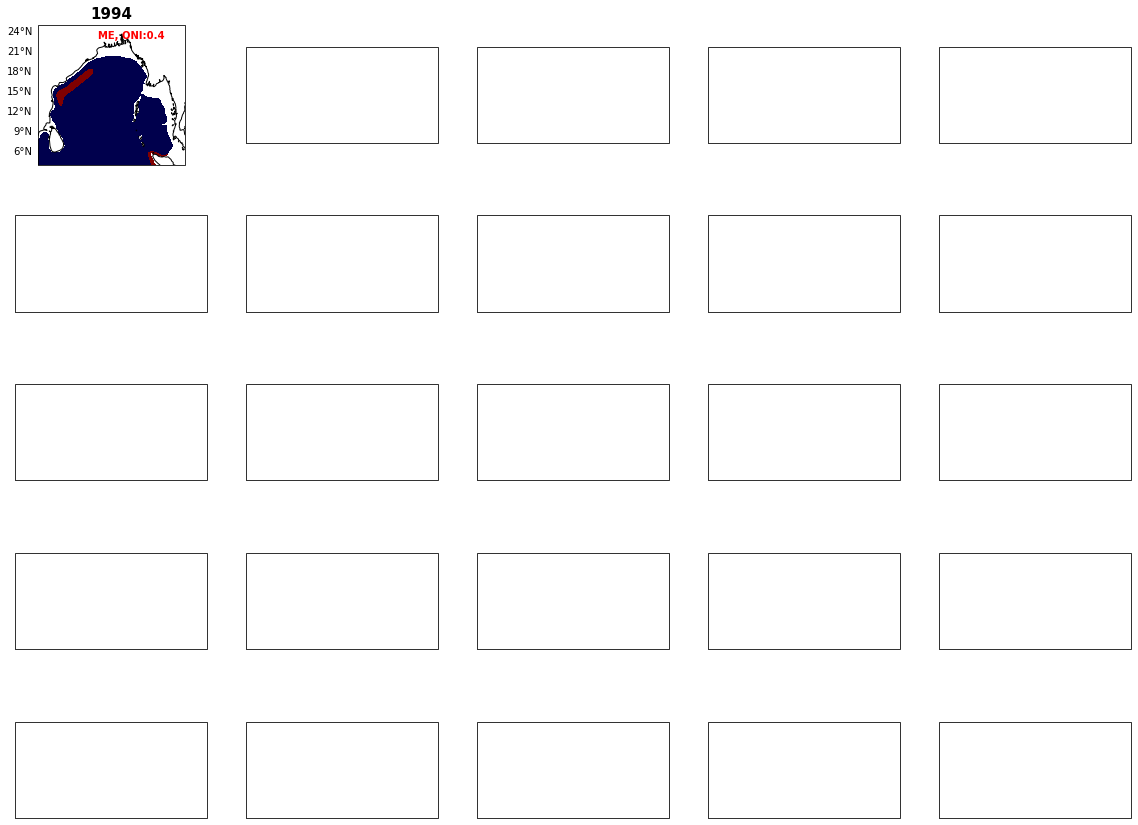

In [74]:
########## Data ########
AS_unfiltered_summer={}
for i in range(1994,2019):
    summer_unfiltered=lcs_sla.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
    AS_unfiltered_summer[i]=[]
    AS_unfiltered_summer[i].append(summer_unfiltered)
    
########## Info ######
Summer_enso_info={}
Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                    1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                    2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                    2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                    2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                    2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]

##########   Ploting ###########
fig, axs = plt.subplots(nrows=5,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

axs=axs.flatten()
y_label=set([0,5,10,15,20])
x_label=set([20,21,22,23,24])
levels=[-20,-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15,20]
for i,year in enumerate(AS_unfiltered_summer):
        data=AS_unfiltered_summer[year]
        cs=axs[i].contourf(lcs_sla.lon.data,lcs_sla.lat.data,data[0],
                          levels=levels,transform = ccrs.PlateCarree(),
                          cmap='seismic',extend='both')
        axs[i].set_extent([78,100,4,25])
        axs[i].set_title(year,fontsize = 15, weight='bold')
        axs[i].coastlines()
        if i in y_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.bottom_labels = False
            gl.right_labels = False
            #gl.xlines=False
        if i in x_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.left_labels = False
            gl.right_labels = False
        if year in Elnino_years:
            axs[i].text(87,23, Summer_enso_info[year],color='red', fontsize = 10,weight='bold')
        if year in Lanina_years:
            axs[i].text(87,23, Summer_enso_info[year],color='blue', fontsize = 10,weight='bold')

cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
cba=fig.colorbar(cs,cax=cb_ax)
plt.suptitle("Bay of Bengal unfiltered Summer LCSCR",fontsize = 30,weight='bold')
plt.savefig('BoB_unfiltered_lcs.jpg',dpi=100)

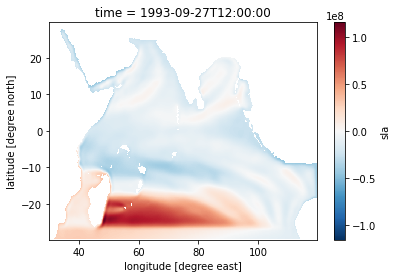

In [27]:
dd1=LCSCR.sla[1000]
dd1.plot()

# filtering

In [15]:
adt=xr.open_mfdataset('lcs_sla1.nc',autoclose=True).sel(lat=slice(4,25),lon=slice(78,100)).sla

In [24]:
def butterworth_lowpass_filter(data, order=2, cutoff_freq=1.0/10.0, axis=0):
    """Filter input data.
    
    For unfiltered data, use `cutoff_freq=1`.
    
    Currently, this returns a numpy array.
    """
    B, A = signal.butter(order, cutoff_freq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

In [29]:
 # intial filters
#adt_unfiltered = butterworth_lowpass_filter(adt, cutoff_freq=.8)
#adt_05day_lowpass = butterworth_lowpass_filter(adt, cutoff_freq=1 / 5.0)
adt_90day_lowpass = butterworth_lowpass_filter(adt, cutoff_freq=1 / 400.0)

# combined filters
#adt_90day_highpass = adt_unfiltered - adt_90day_lowpass
#adt_05day_90day_bandpass = adt_05day_lowpass - adt_90day_lowpass

/home/NCAOR/supriyog/anaconda3/envs/clim/lib/python3.10/site-packages/scipy/signal/_arraytools.py:100: RuntimeWarning: invalid value encountered in subtract
  ext = np.concatenate((2 * left_end - left_ext,
/home/NCAOR/supriyog/anaconda3/envs/clim/lib/python3.10/site-packages/scipy/signal/_arraytools.py:102: RuntimeWarning: invalid value encountered in subtract
  2 * right_end - right_ext),


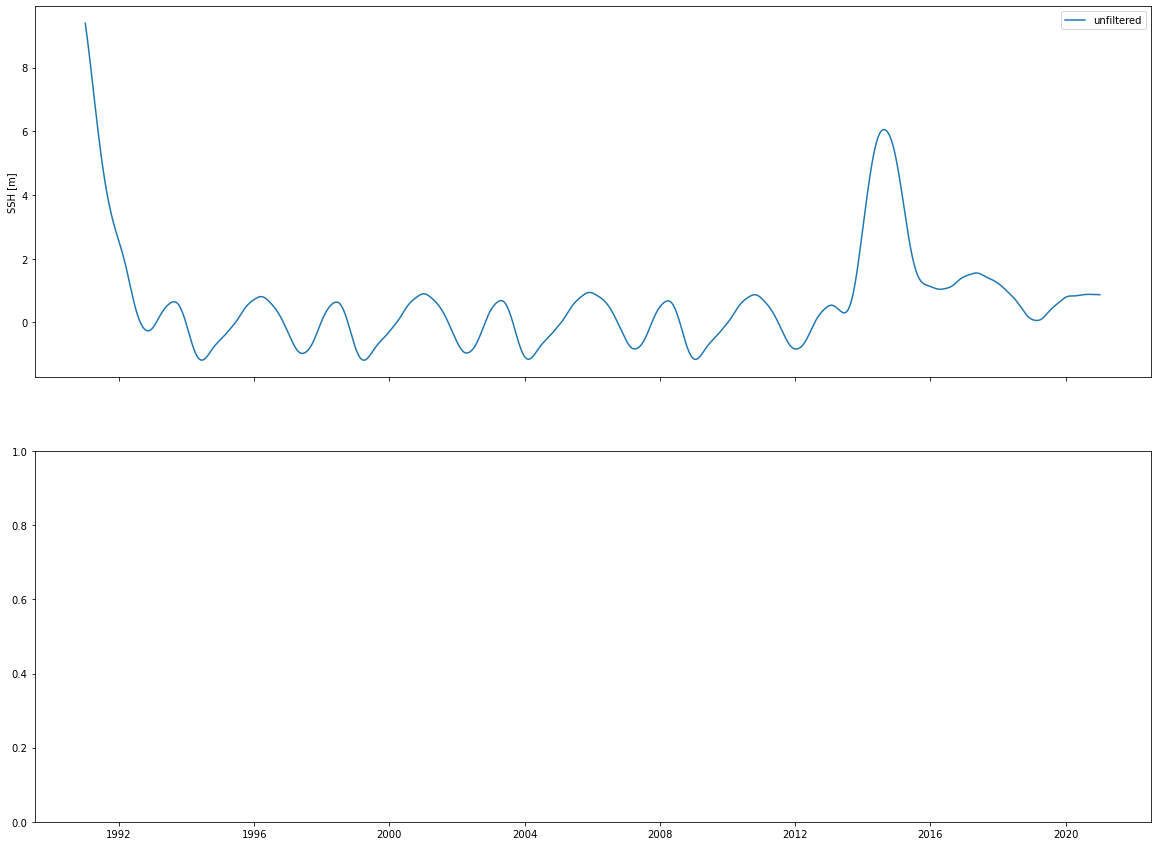

In [52]:
fig, ax = plt.subplots(2, 1, sharex=True,figsize=(20,15))

#ax[0].plot(adt.coords["time"], adt_unfiltered[:, 0, 0]);
#ax[0].plot(adt.coords["time"], adt_05day_lowpass[:, 0, 0]);
ax[0].plot(adt.coords["time"], adt_90day_lowpass[:, 0, 0]);
ax[0].set_ylabel("SSH [m]");
ax[0].legend(["unfiltered", "5day low pass", "400day low pass"], loc=0, ncol=3);

#ax[1].plot(adt.coords["time"], adt_90day_highpass[:, 0, 0]);
#ax[1].plot(adt.coords["time"], adt_05day_90day_bandpass[:, 0, 0]);
#ax[1].set_ylabel("SSH [m]");
#ax[1].legend(["90day high pass", "5day-90day band pass"], loc=0, ncol=2);

In [51]:
d1=adt
d1

<xarray.DataArray 'sla' (time: 10962, lat: 211, lon: 221)>
dask.array<getitem, shape=(10962, 211, 221), dtype=float32, chunksize=(10962, 211, 221), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01T12:00:00 ... 2021-01-04T12:00:00
  * lon      (lon) float32 78.0 78.1 78.2 78.3 78.4 ... 99.7 99.8 99.9 100.0
  * lat      (lat) float32 4.0 4.1 4.2 4.3 4.4 4.5 ... 24.6 24.7 24.8 24.9 25.0

In [58]:
adt

<xarray.DataArray 'sla' (time: 10962, lat: 211, lon: 221)>
dask.array<getitem, shape=(10962, 211, 221), dtype=float32, chunksize=(10962, 211, 221), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01T12:00:00 ... 2021-01-04T12:00:00
  * lon      (lon) float32 78.0 78.1 78.2 78.3 78.4 ... 99.7 99.8 99.9 100.0
  * lat      (lat) float32 4.0 4.1 4.2 4.3 4.4 4.5 ... 24.6 24.7 24.8 24.9 25.0

In [57]:
lat = adt['lat'].values
long = adt['lon'].values
time = adt['time'].values

sla_low = np.array(adt_90day_lowpass).reshape((10962, 1, 1))

me = xr.DataArray(sla_low, coords={'lat': 'lat', 'lon': long, 
                                'time': time},
             dims=[ 'lat', 'lon','time'])
ds['mean_elev'] = me


ValueError: cannot reshape array of size 511169022 into shape (10962,1,1)

In [67]:
d2=xr.DataArray(adt_90day_lowpass,coords={"time": adt.time, "lat": adt.lat,
                          "lon": adt.lon},
                  dims=["time", "lat","lon"])

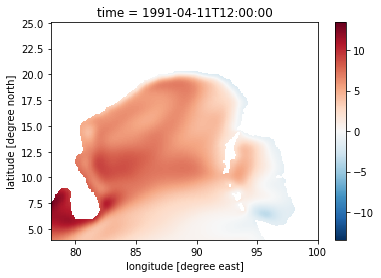

In [71]:
d2[100].plot()